## <u>Accessing Land MODIS Data from the LP DAAC Archive using Web Services</u>

---

To improve access to, and effective utilization of NASA Earth Science data, the Land Processes Distributed Active Archive Center (LP DAAC) has made its collection of tiled land MODIS data sets available for access via OPeNDAP (Open-source Project for a Network Data Access Protocol). As a result, land MODIS data and metadata can be accessed using web services. This tutorial will demonstrate how to use LP DAAC's web services to:
* get land MODIS product information
* get band/layer information from land MODIS products
* extract and plot time series data from a land MODIS product layer for a single point location

**Required Packages**
* requests (http://docs.python-requests.org/en/latest/)
* pandas (http://pandas.pydata.org/)
* matplotlib (http://matplotlib.org/)

**NOTE** 
* This script has been tested and verified using Windows 7 
* Users of this tutorial will need to be connected to the internet in order to successfully execute the python code.
* This script was tested using Python 3.4 and Python 2.7. 

---

## Get information about available MODIS products and layers.

In [1]:
import requests

#### <em>Set LP DAAC services URL.</em>

In [2]:
SERVICES_URL = 'https://lpdaacsvc.cr.usgs.gov/services/appeears-api'

### <em>Request a list of the available land MODIS products.</em>

In [3]:
products_req = requests.get('%s/product?rasterType=tile&format=json' %(SERVICES_URL))
products = products_req.json()

'Information was found for {0} products!'.format(len(products))

'Information was found for 100 products!'

#### Take a look at what was returned. Print a list of available Terra MODIS (MOD) products.
**NOTE**: Can substitute 'MOD' with 'MYD' or 'MCD' to print Aqua MODIS or Combined products respectively.

In [4]:
[p for p in products if "MOD" in p['Product']][0:2]

[{'Available': True,
  'Description': 'Surface Reflectance Bands 1-7',
  'DocLink': 'https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1',
  'Platform': 'Terra MODIS',
  'Product': 'MOD09A1',
  'ProductAndVersion': 'MOD09A1.005',
  'RasterType': 'Tile',
  'Resolution': '500m',
  'Source': 'LP DAAC',
  'TemporalGranularity': '8 day',
  'Version': '005'},
 {'Available': True,
  'Description': 'Reflectance',
  'DocLink': 'https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1_v006',
  'Platform': 'Terra MODIS',
  'Product': 'MOD09A1',
  'ProductAndVersion': 'MOD09A1.006',
  'RasterType': 'Tile',
  'Resolution': '500m',
  'Source': 'LP DAAC',
  'TemporalGranularity': '8 day',
  'Version': '006'}]

**NOTE**: You can also use python slicing (e.g., products[10:16]) to get the returned product information

#### Pull MOD11A1.005 (Land Surface Temperature & Emmissivity) from the product list.

In [5]:
product = next(p for p in products if p['ProductAndVersion'] == 'MOD11A1.005')
product

{'Available': True,
 'Description': 'Land Surface Temperature & Emissivity',
 'DocLink': 'https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod11a1',
 'Platform': 'Terra MODIS',
 'Product': 'MOD11A1',
 'ProductAndVersion': 'MOD11A1.005',
 'RasterType': 'Tile',
 'Resolution': '1000m',
 'Source': 'LP DAAC',
 'TemporalGranularity': 'Daily',
 'Version': '005'}

#### Get layer information for a product of interest. In this case, layer information is requested for MOD11A1.005.

In [6]:
product_layers_req = requests.get('%s/product/%s?format=json' %(SERVICES_URL, product['ProductAndVersion']))
product_layers = product_layers_req.json()
'This product contains {0} layers'.format(len(product_layers))

'This product contains 12 layers'

##### Take a look at some layers returned for MOD11A1.005 using python slicing.

In [7]:
for k in product_layers.keys():
    print(k)

LST_Night_1km
LST_Day_1km
Night_view_angl
Day_view_angl
Clear_day_cov
QC_Day
Emis_31
QC_Night
Emis_32
Night_view_time
Day_view_time
Clear_night_cov


##### Pull out the daytime land surface temperature (LST_Day_1km) layer from the layer list.

In [8]:
product_layer = product_layers['LST_Day_1km']
product_layer

{'Available': True,
 'DataType': 'float32',
 'Description': 'Daily daytime 1km grid Land-surface Temperature',
 'Dimensions': ['time', 'YDim', 'XDim'],
 'FillValue': 0.0,
 'Layer': 'LST_Day_1km',
 'OrigDataType': 'uint16',
 'QualityLayers': "['QC_Day']",
 'QualityProductAndVersion': 'MOD11A1.005',
 'ValidMax': 1310.699951,
 'ValidMin': 150.0,
 'XSize': 1200,
 'YSize': 1200}

###### Get the layer name.

In [9]:
product_layer['Layer']

'LST_Day_1km'

###### Get the quality layer name.

In [10]:
product_layer['QualityLayers']

"['QC_Day']"

---

## Use the LP DAAC's sample service to extract land MODIS data.

### Extract daily Land Surface Temperature (LST) data from the MOD11A1.005 product for a point location. 

##### Specify the latitude and longitude for a point of interest.

In [11]:
latitude, longitude = '45.50894', '-89.58637'

##### Create a variable containing the URL to the sample service.

In [12]:
sample_url = '{0}/sample?'.format(SERVICES_URL)

##### The sample service requires the following arguments: the MODIS product (e.g., MOD11A1.005), the product layer (e.g., LST_Day_1km), a start and end date, the point location (i.e., latitude and longitude), and the format of the returned data (we only support json at this time).
**NOTE**: MODIS products requested through the sample service are specified using the product and version (e.g., MOD11A1.005)

In [13]:
sample_args = {
    'product': product['ProductAndVersion'],
    'layer': product_layer['Layer'],
    'startdate': '03-01-2005',
    'enddate': '09-01-2005',
    'coordinate': '{0},{1}'.format(latitude, longitude),
    'format': 'json'
}

##### Use the sample service to make the data request for the point of interest.
**NOTE**: Completion time will vary depending on the date range requested and/or on the temporal resolution of the data set

In [14]:
sample_req = requests.get(sample_url, params = sample_args)

**NOTE**: As with most things in python, there are many ways to assemble the arguments for an HTTP request. One can get the same information back by simply passing the fully constructed URL, with parameters, to the requests.get() command (e.g., sample_req = requests.get('https://lpdaacsvc.cr.usgs.gov/api/sample?product=MOD11A1.005&layer=LST_Day_1km&startdate=03-01-2005&enddate=09-01-2005&coordinate=45.50894,-89.58637&format=json').

##### Print a subset of the returned data.

In [15]:
samples = sample_req.json()
samples[0:3]

[{'Date': '2005-03-01T00:00:00.000Z',
  'Latitude': 45.50894,
  'Longitude': -89.58637,
  'MOD11A1_005_LST_Day_1km': 0.0,
  'MOD11A1_005_Line_Y_1km': 538,
  'MOD11A1_005_QC_Day': 2,
  'MOD11A1_005_QC_Day_MODLAND': 2,
  'MOD11A1_005_QC_Day_MODLAND_DESC': 'LST not produced due to cloud effects',
  'MOD11A1_005_Sample_X_1km': 866,
  'MODIS_Tile': 'h11v04'},
 {'Date': '2005-03-02T00:00:00.000Z',
  'Latitude': 45.50894,
  'Longitude': -89.58637,
  'MOD11A1_005_LST_Day_1km': 0.0,
  'MOD11A1_005_Line_Y_1km': 538,
  'MOD11A1_005_QC_Day': 2,
  'MOD11A1_005_QC_Day_MODLAND': 2,
  'MOD11A1_005_QC_Day_MODLAND_DESC': 'LST not produced due to cloud effects',
  'MOD11A1_005_Sample_X_1km': 866,
  'MODIS_Tile': 'h11v04'},
 {'Date': '2005-03-03T00:00:00.000Z',
  'Latitude': 45.50894,
  'Longitude': -89.58637,
  'MOD11A1_005_LST_Day_1km': 263.79998779296875,
  'MOD11A1_005_Line_Y_1km': 538,
  'MOD11A1_005_QC_Day': 0,
  'MOD11A1_005_QC_Day_MODLAND': 0,
  'MOD11A1_005_QC_Day_MODLAND_DESC': 'LST produced, go

---

## Explore the MODIS LST data.

#### Convert returned data to a pandas dataframe.

In [16]:
import pandas as pd
lstData = pd.DataFrame.from_dict(samples)

###### Get dataframe information.

In [17]:
lstData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185 entries, 0 to 184
Data columns (total 10 columns):
Date                               185 non-null object
Latitude                           185 non-null float64
Longitude                          185 non-null float64
MOD11A1_005_LST_Day_1km            185 non-null float64
MOD11A1_005_Line_Y_1km             185 non-null int64
MOD11A1_005_QC_Day                 185 non-null int64
MOD11A1_005_QC_Day_MODLAND         185 non-null int64
MOD11A1_005_QC_Day_MODLAND_DESC    185 non-null object
MOD11A1_005_Sample_X_1km           185 non-null int64
MODIS_Tile                         185 non-null object
dtypes: float64(3), int64(4), object(3)
memory usage: 15.9+ KB


###### Take a look at the first 5 records in the dataframe.

In [18]:
lstData.head()

,Date,Latitude,Longitude,MOD11A1_005_LST_Day_1km,MOD11A1_005_Line_Y_1km,MOD11A1_005_QC_Day,MOD11A1_005_QC_Day_MODLAND,MOD11A1_005_QC_Day_MODLAND_DESC,MOD11A1_005_Sample_X_1km,MODIS_Tile
0,2005-03-01T00:00:00.000Z,45.50894,-89.58637,0.000000,538,2,2,LST not produced due to cloud effects,866,h11v04
1,2005-03-02T00:00:00.000Z,45.50894,-89.58637,0.000000,538,2,2,LST not produced due to cloud effects,866,h11v04
2,2005-03-03T00:00:00.000Z,45.50894,-89.58637,263.799988,538,0,0,"LST produced, good quality, not necessary to e...",866,h11v04
3,2005-03-04T00:00:00.000Z,45.50894,-89.58637,0.000000,538,2,2,LST not produced due to cloud effects,866,h11v04
4,2005-03-05T00:00:00.000Z,45.50894,-89.58637,273.440002,538,65,1,"LST produced, unreliable or unquantifiable qua...",866,h11v04


#### <em>Plot returned data, including no data records.</em>
**NOTE**: No data records for MOD11A1_005_LST_Day_1km are assigned as '0'

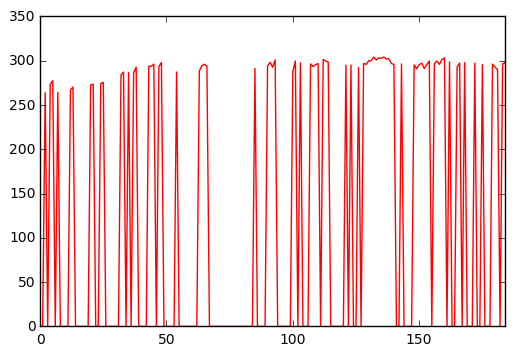

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

lstData['MOD11A1_005_LST_Day_1km'].plot(kind='line', color='red')

#### <em>Plot returned data, excluding no data records.</em>

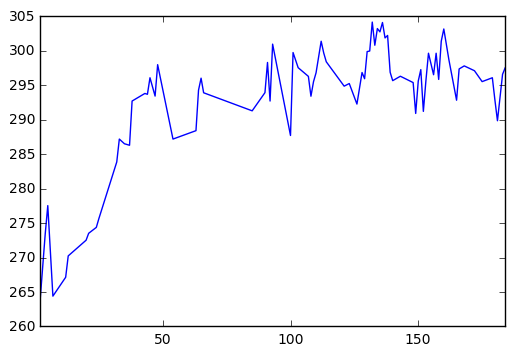

In [20]:
lstData[lstData['MOD11A1_005_LST_Day_1km'] > 0]['MOD11A1_005_LST_Day_1km'].plot(kind='line', color='blue')